In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
import math
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, Pool
import lightgbm as lgb

pd.set_option('display.max_columns', 500)

/Users/s.komissarov/opt/anaconda3/envs/test/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
class Model:
    def __init__(self, cat_features_indices, params={'n_estimators': 500, 'learning_rate': 0.07}):
        self.cat_features_indices = cat_features_indices
        self.params = params
        
    def fit(self, X, y):
        pool = Pool(X, y, cat_features=self.cat_features_indices)
        self.model = CatBoostClassifier()
        self.model.set_params(**self.params)
        
        self.model.fit(pool)
        
    def predict(self, X):
        pool = Pool(X, cat_features=self.cat_features_indices)
        
        pred = self.model.predict_proba(pool)[:, 1]
        return pred
    
    def score(self, X, y):
        pred = self.predict(X)
        
        roc_auc_value = roc_auc_score(y, pred)
        log_loss_value = log_loss(y, pred)
        return roc_auc_value, log_loss_value
    
    def cross_validate(self, X, y):
        roc_auc_list = []
        log_loss_list = []
        kf = RepeatedStratifiedKFold(5, 5, random_state=1)
        
        for train_idx, test_idx in kf.split(X, y):
            X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
            y_train, y_test = y[train_idx], y[test_idx]
            
            self.fit(X_train, y_train)
            ra, ll = self.score(X_test, y_test)
            
            roc_auc_list.append(ra)
            log_loss_list.append(ll)
        
        self.fit(X, y)
            
        print('ROC AUC: {}'.format(np.mean(roc_auc_list)))
        print('LOG LOSS: {}'.format(np.mean(log_loss_list)))
        print('roc auc folds std: {}'.format(np.std(roc_auc_list)))
        print('log loss folds std: {}'.format(np.std(log_loss_list)))
        return self.model

In [3]:
def get_deadline(row):
    if row['wave_id'] == 1:
        return row['Level'] < 7
    if row['wave_id'] == 2:
        return row['Level'] < 5
    if row['wave_id'] == 3:
        return row['Level'] < 4
    return False

def trimAndReplaceCity(city):
    if pd.isna(city) :
        return ''
    city = city.lstrip()
    if city.lower().__contains__('москв') :
        return 'Москва'
    if city.lower().__contains__('Moscow') :
        return 'Москва'
    if city.find('г.') > -1:
        return city.replace('г.', ' ').strip()
    if city.find('с.') > -1:
        return city.replace('с.', ' ').strip()
    if city.find('С.') > -1:
        return city.replace('С.', ' ').strip()
    if city.find('п.') > -1:
        return city.replace('п.', ' ').strip()
    if city.find('дер.') > -1:
        return city.replace('дер.', ' ').strip()
    if city.find('Дер.') > -1:
        return city.replace('Дер.', ' ').strip()
    if city.find('Г.') > -1:
        return city.replace('Г.', ' ').strip()
    return city

def prep_features(data):
    df = data.copy().rename({'Native city': 'city',
                             'Wave id': 'wave_id'}, axis=1)
    cities = pd.read_csv('data/cities_features.csv', names=['city', 'f1', 'f2','f3', 'f4','f5', 'f6', 'f7', 'f8'])
    cities = cities.sort_values(by='f1', ascending=False).drop_duplicates('city', keep='first')
    df['city'] = df['city'].apply(trimAndReplaceCity)
    df = df.merge(cities, on='city', how='left')
    df.index = data.index
    df['age'] = ((datetime.now() - df['Birth date']).dt.days / 365).apply(math.floor)
    df['contract'] = df['Contract termination date'].isna().astype('int64')
    df['Life status'] = df['Life status'].astype(str)
    df['fail_deadline'] = df.apply(get_deadline, axis=1).astype(int)
    df['total_days'] = df[['day_00', 'day_01', 'day_02', 'day_03', 'day_04',
                           'day_05', 'day_06', 'day_07', 'day_08', 'day_09',
                           'day_10', 'day_11', 'day_12', 'day_13']].sum(axis=1)
    df['total_solo_projects'] = df[['evalexpr', 'match_n_match', 'bsq']].sum(axis=1)
    df['total_rushes'] = df[['rush_00', 'rush_01', 'rush_02']].sum(axis=1)
    df['total_exams'] = df[['exam_00', 'exam_01', 'exam_02', 'exam_final']].sum(axis=1)
    df['total_all_projects'] = df[['total_days', 'total_solo_projects',
                                   'total_rushes', 'total_exams']].sum(axis=1)
    df['nan_projects'] = df[['day_00', 'day_01', 'day_02', 'day_03', 'day_04',
                             'day_05', 'day_06', 'day_07', 'day_08', 'day_09',
                             'day_10', 'day_11', 'day_12', 'day_13',
                             'evalexpr', 'match_n_match', 'bsq',
                             'rush_00', 'rush_01', 'rush_02',
                             'exam_00', 'exam_01', 'exam_02', 'exam_final']].isna().sum(axis=1)
    df['zero_projects'] = (df[['day_00', 'day_01', 'day_02', 'day_03', 'day_04',
                              'day_05', 'day_06', 'day_07', 'day_08', 'day_09',
                              'day_10', 'day_11', 'day_12', 'day_13',
                              'evalexpr', 'match_n_match', 'bsq',
                              'rush_00', 'rush_01', 'rush_02',
                              'exam_00', 'exam_01', 'exam_02', 'exam_final']] == 0).sum(axis=1)
    
#     wave_dates = (pd.read_csv('data/waves_dates.csv', parse_dates=['date'])
#               .rename(columns={'id': 'wave_id',
#                                'date': 'wave_date'}))
    
#     df = df.merge(wave_dates, how='left', on='wave_id')
#     df.index = data.index
#     df['lvl_speed'] = df['Level'] / (pd.to_datetime('today').date() - df['wave_date'].dt.date).dt.days
#     df['lvl_wave_id'] = df['Level']..astype(str) + df['wave_id'].astype(str)
    return df

In [4]:
train = pd.read_csv('data/train.csv', index_col=0, parse_dates=[1, 32])
train = train[train['Wave id'] != 4]
features = ['age','Gender', 'Level', 'Life status',
#             'day_00', 'day_01', 'day_02', 'day_03', 'day_04',
#             'day_05', 'day_06', 'day_07', 'day_08', 'day_09',
#             'day_10', 'day_11', 'day_12', 'day_13',
#             'evalexpr', 'match_n_match', 'bsq',
#             'rush_00', 'rush_01', 'rush_02',
            'exam_00', 'exam_01', 'exam_02', 'exam_final',
#             'f1', 'f2','f3', 'f4','f5', 'f6', 'f7', 'f8',
            'total_days', 'total_solo_projects', 'total_rushes', 'total_exams', 'total_all_projects',
            'nan_projects', 'zero_projects',
            'contract', 'Memory entrance game',
            'Logic entrance game',
            'wave_id', 'fail_deadline'
#             'lvl_speed'
           ]
data = prep_features(train)[features]
y = train['contract_status'].values

In [5]:
X = data

map_feature_index = {j:i for i,j in enumerate(X.columns)}
# cat_features = ['Gender', 'Life status']
cat_features = ['Gender', 'Life status', 'wave_id']
cat_features_indices = [map_feature_index[i] for i in cat_features]

model_params = {
    'random_state': 12,
    'n_estimators': 700,
    'learning_rate': 0.03,
    'depth': 5,
    'verbose': 500
}

model = Model(cat_features_indices, model_params)
model.cross_validate(X, y)

0:	learn: 0.6516055	total: 64.1ms	remaining: 44.8s
500:	learn: 0.0422230	total: 1.2s	remaining: 477ms
699:	learn: 0.0292123	total: 1.63s	remaining: 0us
0:	learn: 0.6589880	total: 2.13ms	remaining: 1.49s
500:	learn: 0.0324848	total: 1.04s	remaining: 415ms
699:	learn: 0.0215329	total: 1.47s	remaining: 0us
0:	learn: 0.6472075	total: 2.07ms	remaining: 1.45s
500:	learn: 0.0338704	total: 1.02s	remaining: 406ms
699:	learn: 0.0231248	total: 1.45s	remaining: 0us
0:	learn: 0.6510734	total: 2.03ms	remaining: 1.42s
500:	learn: 0.0371834	total: 1.09s	remaining: 433ms
699:	learn: 0.0234102	total: 1.51s	remaining: 0us
0:	learn: 0.6532553	total: 2.29ms	remaining: 1.6s
500:	learn: 0.0457514	total: 1.03s	remaining: 411ms
699:	learn: 0.0316844	total: 1.45s	remaining: 0us
0:	learn: 0.6482943	total: 2ms	remaining: 1.4s
500:	learn: 0.0361658	total: 1.03s	remaining: 410ms
699:	learn: 0.0240590	total: 1.43s	remaining: 0us
0:	learn: 0.6496365	total: 2.02ms	remaining: 1.41s
500:	learn: 0.0409611	total: 1.05s	re

In [6]:
def make_prediction_file(model):
    test = pd.read_csv('data/test.csv', index_col=0, parse_dates=[1])
    
    test_df = prep_features(test)[features]
    pred = model.predict(test_df)
    pred[test_df['wave_id'] == 4] = 1
    pred_df = pd.DataFrame(pred, index=test_df.index).reset_index()
    pred_df.to_csv('prediction_best_cv.csv', header=['id', 'contract_status'], index=False)
    return pred_df


In [7]:
pred = make_prediction_file(model)

In [8]:
roc_auc_list = []
log_loss_list = []
kf = RepeatedStratifiedKFold(5, 5, random_state=1)

X_tmp = X.copy()
X_tmp['Gender'] = X_tmp['Gender'].map({'male': 1, 'female': 0})
X_tmp['Life status'] = X_tmp['Life status'].map({'work': 0, 'nan': 1, 'other': 2, 'study': 3})

lgb_params = {
    'random_state': 42,
    'objective': 'binary',
    'metric': 'logloss',
    'verbosity': -1,
    'num_rounds': 500
}

for train_idx, test_idx in kf.split(X_tmp, y):
    X_train, X_test = X_tmp.iloc[train_idx, :], X_tmp.iloc[test_idx, :]
    y_train, y_test = y[train_idx], y[test_idx]

    train_lgb = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    eval_lgb = lgb.Dataset(X_test, label=y_test, categorical_feature=cat_features)
    
    lgb_model = lgb.train(lgb_params, train_lgb, verbose_eval=50, num_boost_round=500, valid_sets=eval_lgb)
    pred = lgb_model.predict(X_test)
    ra = roc_auc_score(y_test, pred)
    ll = log_loss(y_test, pred)

    roc_auc_list.append(ra)
    log_loss_list.append(ll)

# self.fit(X, y)

print('ROC AUC: {}'.format(np.mean(roc_auc_list)))
print('LOG LOSS: {}'.format(np.mean(log_loss_list)))
print('roc auc folds std: {}'.format(np.std(roc_auc_list)))
print('log loss folds std: {}'.format(np.std(log_loss_list)))

/Users/s.komissarov/opt/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/s.komissarov/opt/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/s.komissarov/opt/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/s.komissarov/opt/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/s.komissarov/opt/anaconda3/envs/test/lib/python3.7/site-packages/ligh

/Users/s.komissarov/opt/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/s.komissarov/opt/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/s.komissarov/opt/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/s.komissarov/opt/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/s.komissarov/opt/anaconda3/envs/test/lib/python3.7/site-packages/ligh

ROC AUC: 0.9512350873264667
LOG LOSS: 0.45503891414087233
roc auc folds std: 0.01962895205370322
log loss folds std: 0.1211445018762253


In [9]:
train_lgb = lgb.Dataset(X_tmp, label=y, categorical_feature=cat_features)

lgb_model = lgb.train(lgb_params, train_lgb, verbose_eval=50, num_boost_round=500)
test = pd.read_csv('data/test.csv', index_col=0, parse_dates=[1])
test_df = prep_features(test)[features]
test_df['Gender'] = test_df['Gender'].map({'male': 1, 'female': 0})
test_df['Life status'] = test_df['Life status'].map({'work': 0, 'nan': 1, 'other': 2, 'study': 3})
pred = lgb_model.predict(test_df)
pd.DataFrame(pred, index=test_df.index).reset_index().to_csv('prediction.csv', header=['id', 'contract_status'], index=False)

/Users/s.komissarov/opt/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/s.komissarov/opt/anaconda3/envs/test/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [10]:
def get_feature_importance(model):
    feature_importance = model.model.get_feature_importance(Pool(X,label=y, cat_features=cat_features_indices))
    feature_score = pd.DataFrame(list(zip(X.dtypes.index, feature_importance)), 
                                 columns=['Feature','Score'])
    feature_score = feature_score.sort_values(by='Score',
                                              ascending=False,
                                              inplace=False,
                                              kind='quicksort',
                                              na_position='last')
    plt.rcParams["figure.figsize"] = (12,7)
    ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
    ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
    ax.set_xlabel('')

    rects = ax.patches

    labels = feature_score['Score'].round(2)

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

    plt.show()
    return feature_score

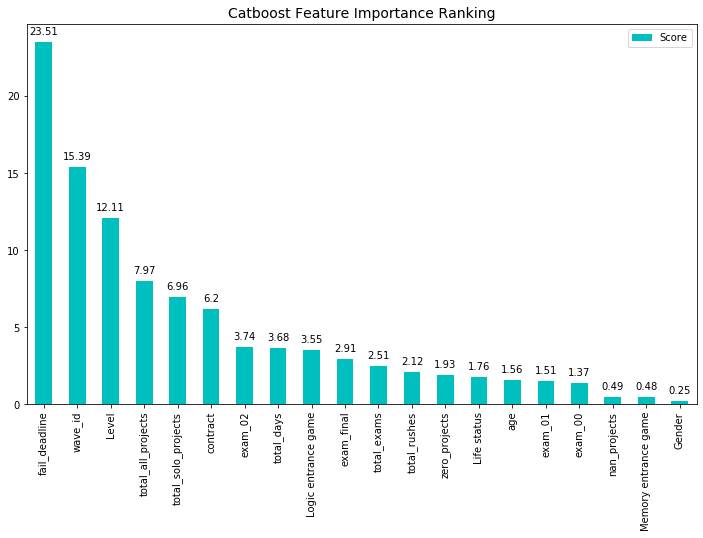

,Feature,Score
19,fail_deadline,23.513865
18,wave_id,15.387919
2,Level,12.114995
12,total_all_projects,7.971909
9,total_solo_projects,6.958632
15,contract,6.202600
6,exam_02,3.742123
8,total_days,3.679647
17,Logic entrance game,3.550836
7,exam_final,2.912150


In [11]:
get_feature_importance(model)

In [12]:
test[test['Birth date'] == pd.to_datetime('1991-08-04')]

,Birth date,Native city,Gender,Wave id,Level,Heard about school from,Life status,day_00,day_01,day_02,day_03,day_04,day_05,day_06,day_07,day_08,day_09,day_10,day_11,day_12,day_13,evalexpr,match_n_match,bsq,rush_00,rush_01,rush_02,exam_00,exam_01,exam_02,exam_final,Contract termination date,Memory entrance game,Logic entrance game
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1887023796,1991-08-04,Москва,male,2,8.016234,NaN,NaN,5,NaN,0.0,20.0,5.0,0.0,20.0,0.0,0.0,0.0,20.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,55.0,48.0,48.0,26.0,NaN,8,10
478971766,1991-08-04,Москва,female,1,5.966981,vk_ads,other,30,60.0,10.0,40.0,55.0,7.0,20.0,20.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,32.0,36.0,2019-10-22T21:00:00+03:00,9,14


In [13]:
cols = ['day_00', 'day_01', 'day_02',
       'day_03', 'day_04', 'day_05', 'day_06', 'day_07', 'day_08', 'day_09',
       'day_10', 'day_11', 'day_12', 'day_13', 'evalexpr', 'match_n_match',
       'bsq', 'rush_00', 'rush_01', 'rush_02', 'exam_00', 'exam_01', 'exam_02',
       'exam_final']

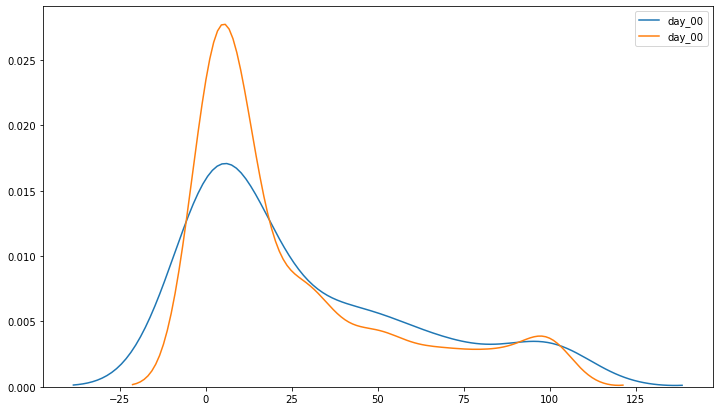

/Users/s.komissarov/opt/anaconda3/envs/test/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/s.komissarov/opt/anaconda3/envs/test/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


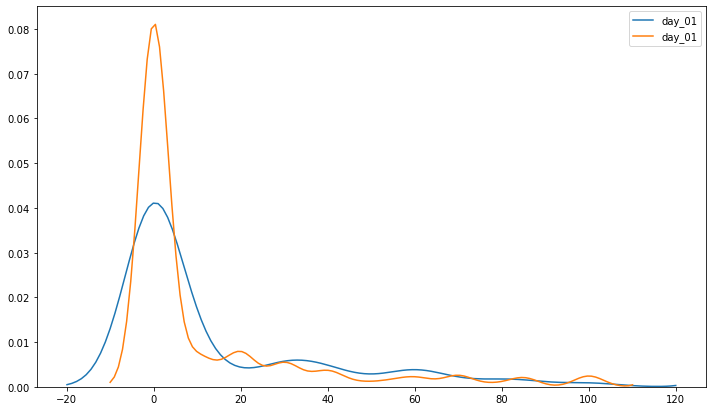

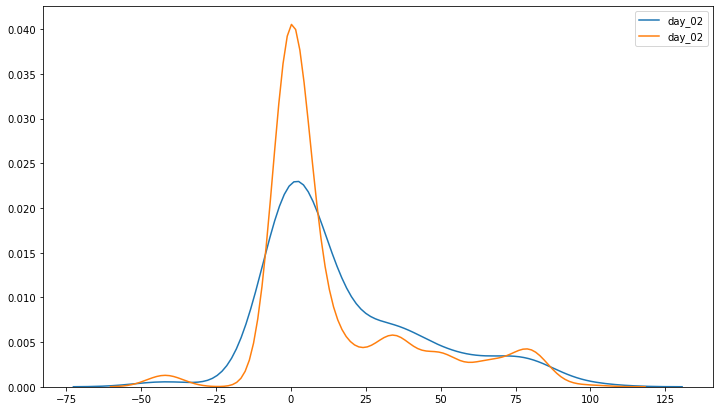

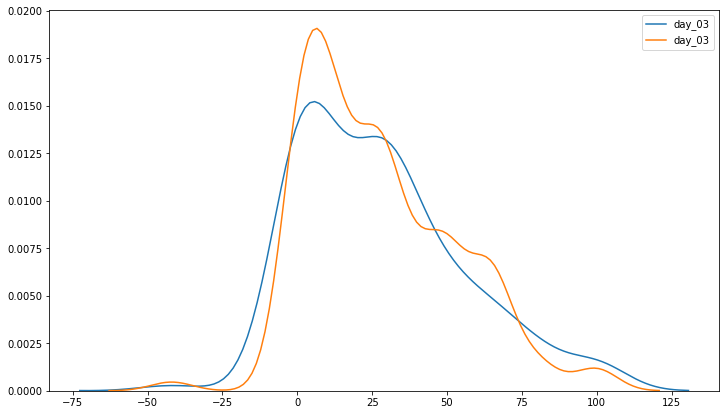

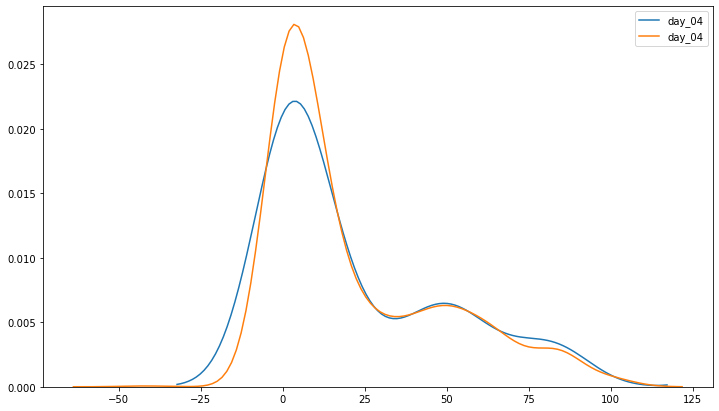

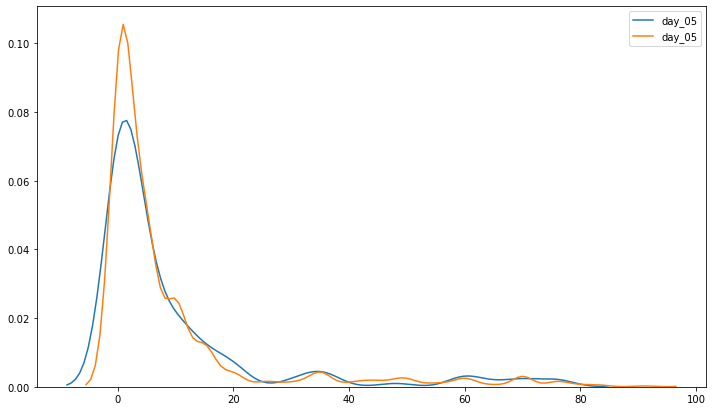

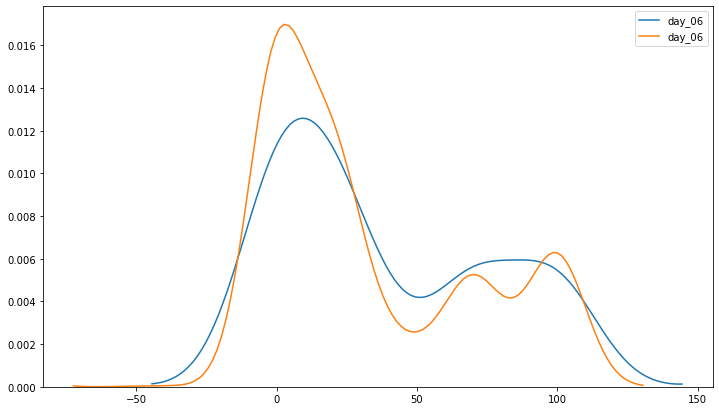

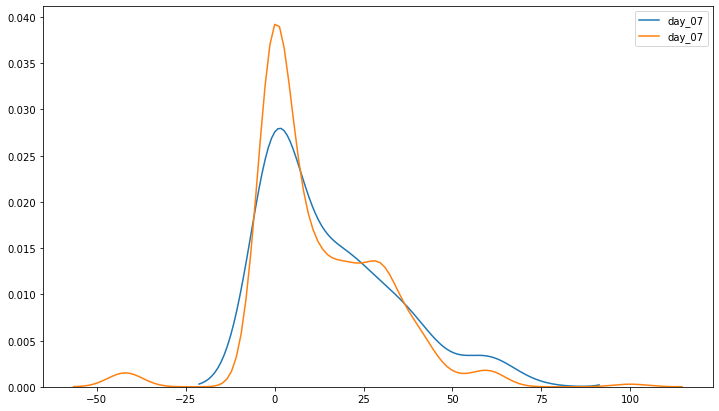

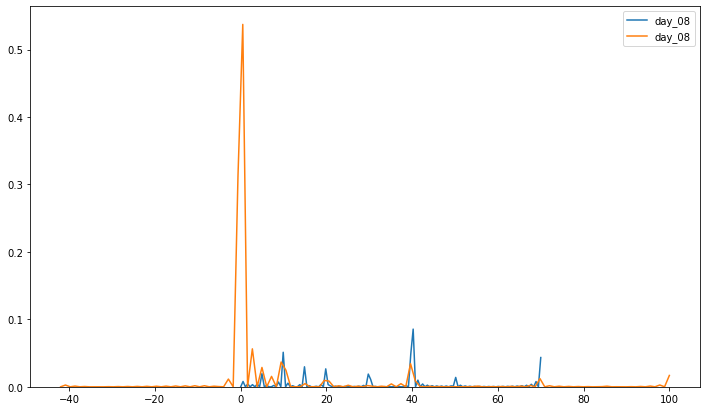

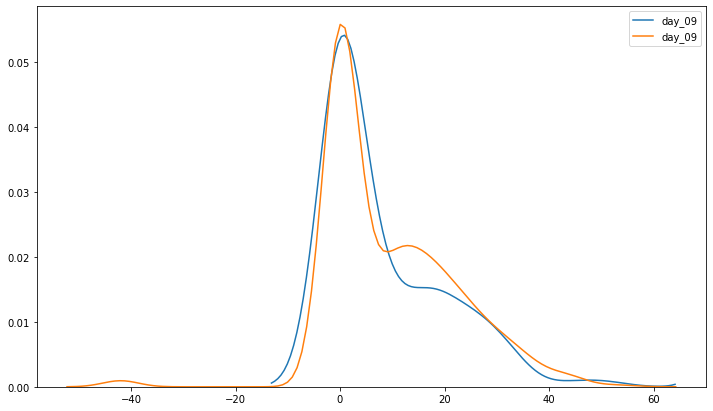

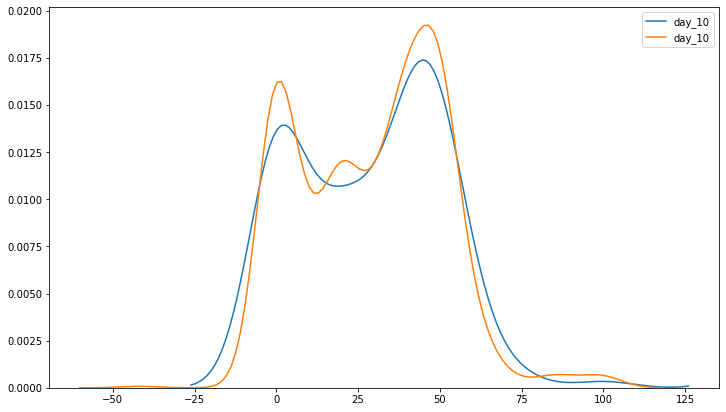

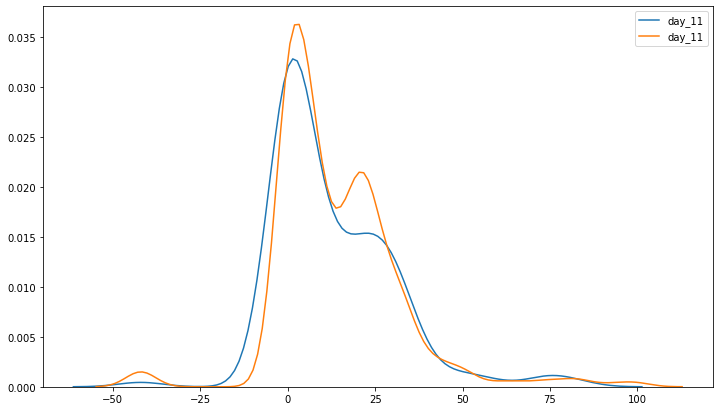

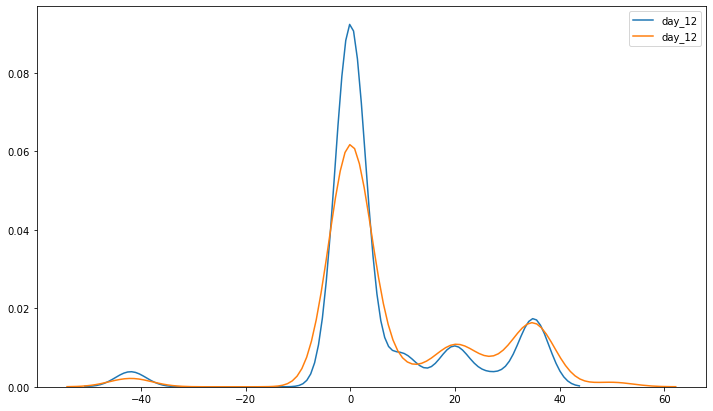

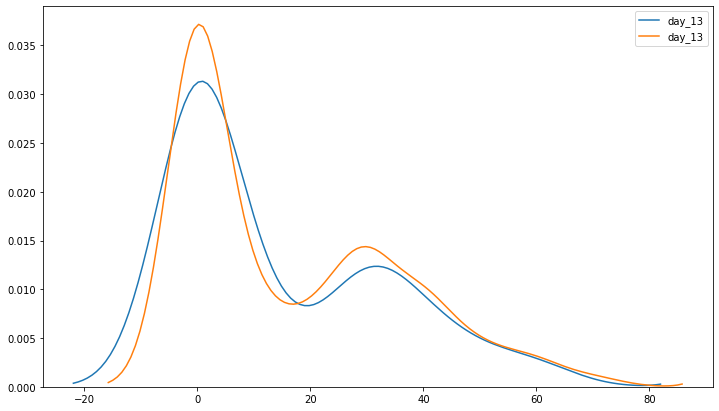

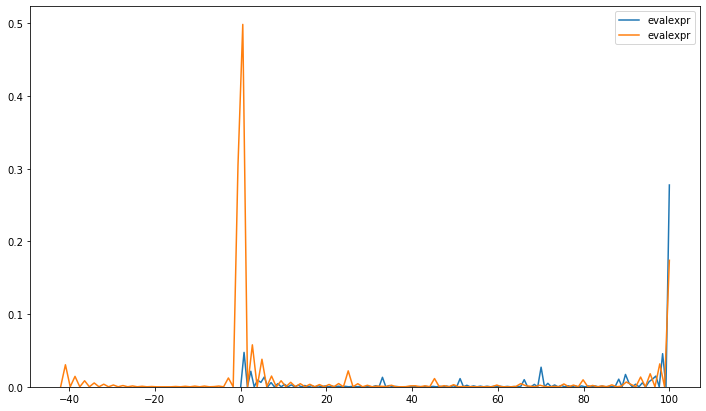

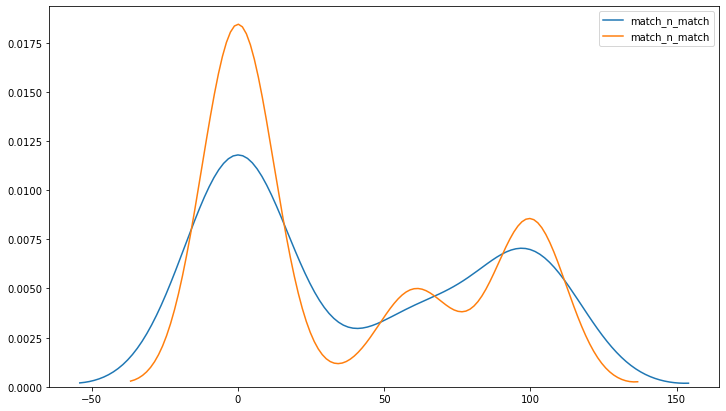

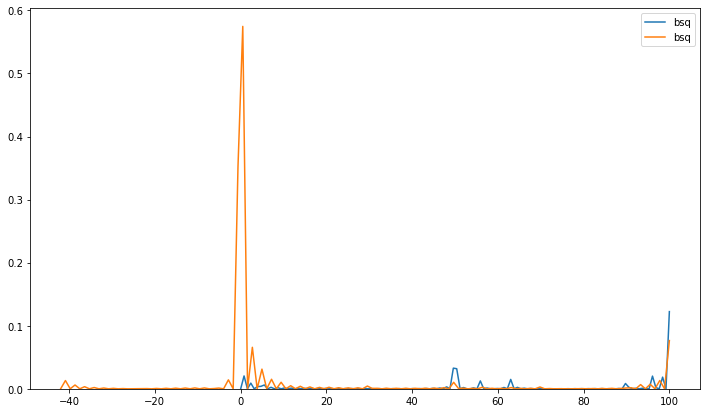

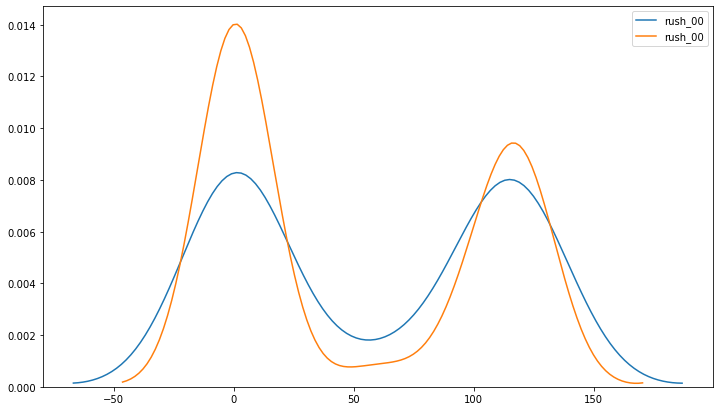

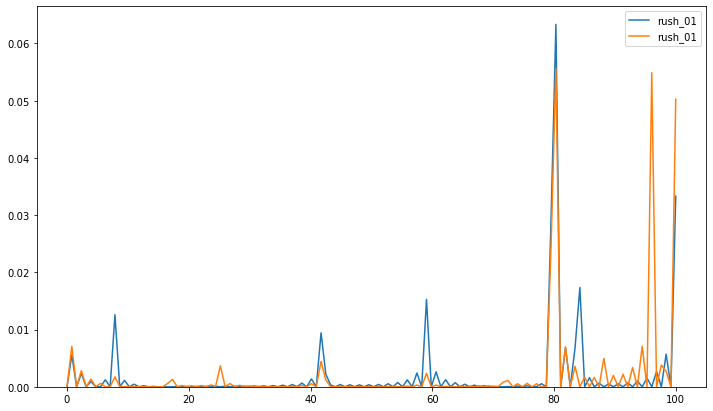

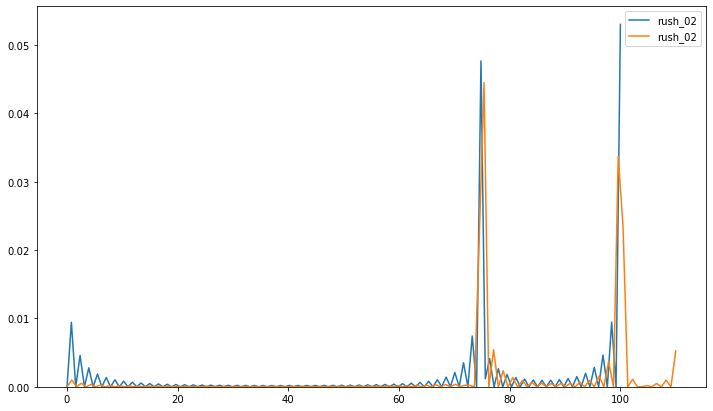

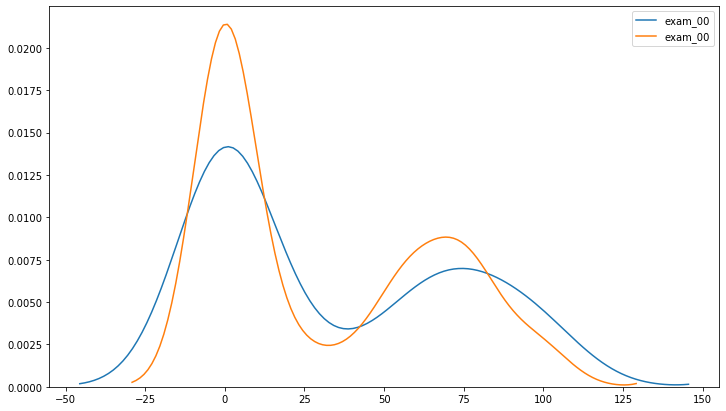

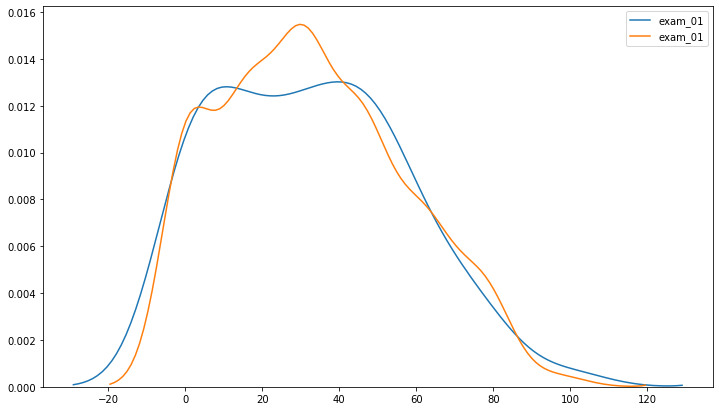

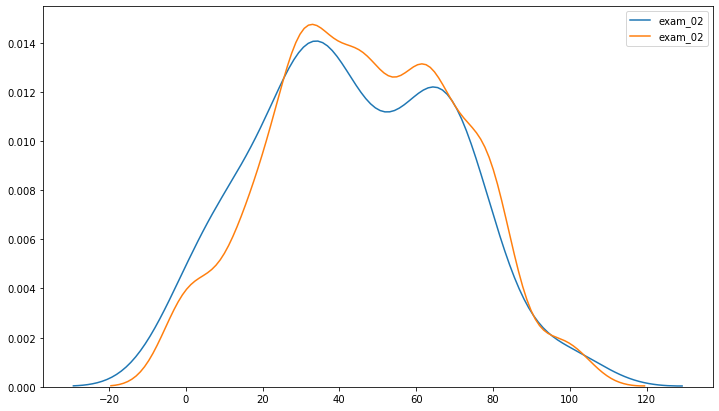

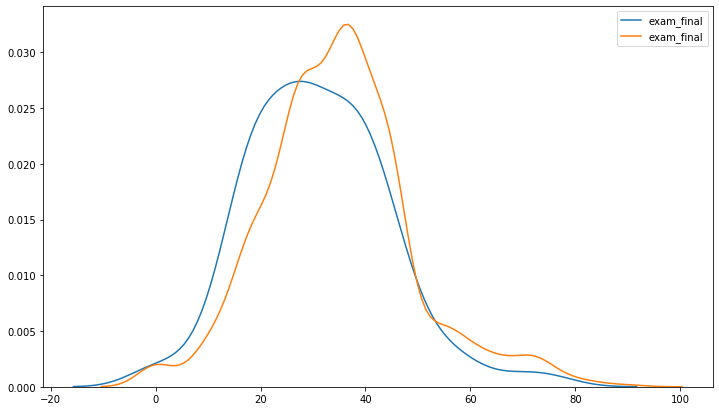

In [14]:
for n in cols:
    sns.kdeplot(train[train['contract_status'] == 0][n], label=n)
    sns.kdeplot(train[train['contract_status'] == 1][n], label=n)
    plt.show()

In [15]:
sns.kdeplot?